In [3]:
import numpy as np
import math
import torch

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.visualization.scatter import Scatter
# BoTorch Pairwise imports
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch import fit_gpytorch_mll

##############################################################################
# 1. ZDT1 (진짜 블랙박스, 사용자 대행)
##############################################################################
def zdt1_f0(x: np.ndarray):
    return x[0]

def zdt1_f1(x: np.ndarray):
    D = len(x)
    g = 1.0 + 9.0 * (np.sum(x[1:]) / (D - 1))
    return g * (1.0 - math.sqrt(x[0]/g))
def zdt1_distance_from_pf(f0, f1):
    """
    ZDT1의 진짜 파레토는 f1 = 1 - sqrt(f0).
    여기에 얼마나 가까운지 절댓값 차로 계산.
    """
    return abs(f1 - (1.0 - np.sqrt(f0)))
def evaluate_zdt1(X: np.ndarray):
    """
    X.shape=(N, dim), return (N,2)
    """
    N, D = X.shape
    vals = np.zeros((N,2))
    for i in range(N):
        xi = X[i]
        vals[i,0] = zdt1_f0(xi)
        vals[i,1] = zdt1_f1(xi)
    return vals

##############################################################################
# 2. MultiPreferenceGP (PairwiseGP 2개: pref1, pref2)
##############################################################################
class MultiPreferenceGP:
    """
    pref1: x[0]만 사용 → PairwiseGP #1
    pref2: 전체 x 사용 → PairwiseGP #2
    + observe_preference(winner, losers)에 따라 pairwise 데이터 추가
    + _fit_gp1(), _fit_gp2() 로 재학습
    + predict_gp1, predict_gp2로 posterior mean, std 구해 UCB 계산 가능
    """

    def __init__(self, dimension=5, threshold=1e-9, device=None):
        if device is None:
            device = torch.device("cpu")
        self.device = device
        self.dimension = dimension
        self.threshold = threshold

        self.observed_x = []  # list of np.ndarray(shape=(dim,))
        self.comparisons1 = []  # (winner_idx, loser_idx)
        self.comparisons2 = []

        self.gp1 = None
        self.gp2 = None

    def _get_index(self, x: np.ndarray) -> int:
        for i, obs in enumerate(self.observed_x):
            if np.linalg.norm(obs - x) <= self.threshold:
                return i
        self.observed_x.append(x)
        return len(self.observed_x) - 1

    def observe_preference(self, winner_x: np.ndarray, loser_list: list):
        """
        winner_x > each x in loser_list
        pref1, pref2에 pairwise data 저장 후 재학습
        """
        w_idx = self._get_index(winner_x)
        for lx in loser_list:
            l_idx = self._get_index(lx)
            # pref1
            self.comparisons1.append((w_idx, l_idx))
            # pref2
            self.comparisons2.append((w_idx, l_idx))

        self._fit_gp1()
        self._fit_gp2()

    def _fit_gp1(self):
        if len(self.observed_x) < 2 or len(self.comparisons1) == 0:
            self.gp1 = None
            return
        # x[0]만
        X_1 = np.array([[obs[0]] for obs in self.observed_x], dtype=np.float64)
        comps1 = np.array(self.comparisons1, dtype=int)

        train_X_1 = torch.from_numpy(X_1).to(device=self.device, dtype=torch.double)
        comps1_t = torch.from_numpy(comps1).to(device=self.device)

        self.gp1 = PairwiseGP(train_X_1, comps1_t)
        mll1 = PairwiseLaplaceMarginalLogLikelihood(self.gp1.likelihood, self.gp1)
        fit_gpytorch_mll(mll1)

    def _fit_gp2(self):
        if len(self.observed_x) < 2 or len(self.comparisons2) == 0:
            self.gp2 = None
            return
        X_2 = np.array(self.observed_x, dtype=np.float64)
        comps2 = np.array(self.comparisons2, dtype=int)

        train_X_2 = torch.from_numpy(X_2).to(device=self.device, dtype=torch.double)
        comps2_t = torch.from_numpy(comps2).to(device=self.device)

        self.gp2 = PairwiseGP(train_X_2, comps2_t)
        mll2 = PairwiseLaplaceMarginalLogLikelihood(self.gp2.likelihood, self.gp2)
        fit_gpytorch_mll(mll2)

    def predict_gp1_ucb(self, x: np.ndarray, beta=2.0):
        """
        GP1 posterior mean + beta*std
        return scalar
        """
        if self.gp1 is None:
            return 0.0
        x_1 = torch.tensor([[x[0]]], device=self.device, dtype=torch.double)
        with torch.no_grad():
            posterior = self.gp1.posterior(x_1)
            mean = posterior.mean.item()
            var = posterior.variance.item()
        std = math.sqrt(var) if var>0 else 0
        ucb_val = mean + beta*std
        return ucb_val

    def predict_gp2_ucb(self, x: np.ndarray, beta=2.0):
        """
        GP2 posterior mean + beta*std
        """
        if self.gp2 is None:
            return 0.0
        x_2 = torch.tensor([x], device=self.device, dtype=torch.double)
        with torch.no_grad():
            posterior = self.gp2.posterior(x_2)
            mean = posterior.mean.item()
            var = posterior.variance.item()
        std = math.sqrt(var) if var>0 else 0
        return mean + beta*std

##############################################################################
# 3. NSGA-II Problem: GP-UCB 기반 (obj1=-UCB1, obj2=-UCB2)
##############################################################################
class PairwiseGPMOOProblem(Problem):
    """
    NSGA2가 평가 요청할 때,
    - GP1, GP2의 UCB를 구해서 (obj1, obj2) = (-UCB1, -UCB2) 로 반환.
      즉, UCB를 "최대화" -> -UCB를 "최소화"
    """
    def __init__(self, gp_model: MultiPreferenceGP, n_var=5, beta=2.0):
        super().__init__(
            n_var=n_var,
            n_obj=2,
            n_constr=0,
            xl=0.0,
            xu=1.0
        )
        self.gp_model = gp_model
        self.n_var = n_var
        self.beta = beta

    def _evaluate(self, X, out, *args, **kwargs):
        N = X.shape[0]
        F = np.zeros((N,2))
        for i in range(N):
            x_i = X[i]
            # UCB1, UCB2
            ucb1 = self.gp_model.predict_gp1_ucb(x_i, beta=self.beta)
            ucb2 = self.gp_model.predict_gp2_ucb(x_i, beta=self.beta)
            # 목표: UCB 최대화 -> -UCB 최소화
            F[i,0] = -ucb1
            F[i,1] = -ucb2
        out["F"] = F

##############################################################################
# 4. Callback: 사용자가 "non-dominated 해" 중 f2가 큰 해를 더 선호
#    => Winner vs Losers = pairwise data
##############################################################################
class ZDT1PreferenceCallback(Callback):
    """

    """
    def __init__(self, gp_model, top_frac=0.3, pick_k=3, feedback_interval=1):
        """
        top_frac: ND 집합 중 (파레토 거리 작은) 상위 top_frac 비율만 candidate로
        pick_k: 후보 중 무작위로 k개를 winner
        feedback_interval: 몇 세대마다 피드백
        """
        super().__init__()
        self.gp_model = gp_model
        self.top_frac = top_frac
        self.pick_k = pick_k
        self.interval = feedback_interval

    def notify(self, algorithm):
        gen = algorithm.n_gen
        if gen % self.interval == 0 and gen > 0:
            # 현재 population
            pop_X = algorithm.pop.get("X")

            # 실제 zdt1 (가상의 사용자)
            zvals = evaluate_zdt1(pop_X)  # shape=(pop_size,2) => (f0,f1)

            # 1) ND 인덱스 추출
            nds = NonDominatedSorting().do(zvals)
            nd_idx = nds[0]
            nd_X = pop_X[nd_idx]
            nd_F = zvals[nd_idx]  # (f0, f1)

            if len(nd_X) <= 1:
                print(f"[Gen={gen}] ND set size <=1, skip preference.")
                return

            # 2) f1 = 1 - sqrt(f0)에 가까운 순으로 정렬
            #    diff[i] = |f1 - (1 - sqrt(f0))|
            diffs = [
                zdt1_distance_from_pf(nd_F[i,0], nd_F[i,1]) 
                for i in range(len(nd_X))
            ]
            diffs = np.array(diffs)

            # 오름차순 정렬(가장 작은 게 가장 Pareto Front에 가깝다)
            sort_idx = np.argsort(diffs)  # diffs가 작은 순
            # top_k개 winner 인덱스
            # top_frac 비율만큼 candidate
            cutoff = int(np.ceil(len(nd_X) * self.top_frac))
            candidate_idx = sort_idx[:cutoff]

            # 4) candidate 중 pick_k개 무작위로 고른다
            if len(candidate_idx) < self.pick_k:
                print(f"[Gen={gen}] candidate size < pick_k, skip preference.")
                return

            pick_idx = np.random.choice(candidate_idx, size=self.pick_k, replace=False)
            winner_list = [nd_X[i] for i in pick_idx]

            # 나머지 (ND 전체에서) loser
            # => 굳이 ND 전부 loser?  vs ND-(winner)만?  여기선 ND-(winner)로
            losers = []
            for i, x_ in enumerate(nd_X):
                if i not in pick_idx:
                    losers.append(x_)

            # 5) PairwiseGP 업데이트
            # 한 번에 k개 winner를 등록 => (winner_x, losers) 호출 k번
            for w in winner_list:
                self.gp_model.observe_preference(w, losers)
            # 디버그 출력
            dist_values = diffs[pick_idx]
            print(f"[Gen={gen}] ND={len(nd_X)}, top_frac={self.top_frac}, candidate={cutoff} => pick_k={self.pick_k}")
            print("Winners dist range=({:.4e} ~ {:.4e})".format(dist_values.min(), dist_values.max()))

##############################################################################
# 실행 예시
##############################################################################
if __name__ == "__main__":
    from pymoo.termination import get_termination

    dim = 5
    gp_pref = MultiPreferenceGP(dimension=dim)

    problem = PairwiseGPMOOProblem(gp_pref, n_var=dim, beta=0.1)
    algorithm = NSGA2(pop_size=30)

    callback = ZDT1PreferenceCallback(gp_pref, feedback_interval=3)

    res = minimize(
        problem,
        algorithm,
        termination=("n_gen", 100),  # 10세대
        callback=callback,
        seed=123,
        verbose=True
    )

    print("\n=== Done ===")
    print("Final pop size:", len(res.pop))
    print("obs_x size:", len(gp_pref.observed_x))
    print("comparisons1:", len(gp_pref.comparisons1))
    print("comparisons2:", len(gp_pref.comparisons2))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |     30 |             - |             -
     2 |       60 |     30 |  0.000000E+00 |             f
     3 |       90 |     30 |  0.000000E+00 |             f
[Gen=3] candidate size < pick_k, skip preference.
     4 |      120 |     30 |  0.000000E+00 |             f
     5 |      150 |     30 |  0.000000E+00 |             f
     6 |      180 |     30 |  0.000000E+00 |             f
[Gen=6] candidate size < pick_k, skip preference.
     7 |      210 |     30 |  0.000000E+00 |             f
     8 |      240 |     30 |  0.000000E+00 |             f
     9 |      270 |     30 |  0.000000E+00 |             f
[Gen=9] candidate size < pick_k, skip preference.
    10 |      300 |     30 |  0.000000E+00 |             f
    11 |      330 |     30 |  0.000000E+00 |             f
    12 |      360 |     30 |  0.000000E+00 |             f
[Gen=12] candidate size < pick_k, skip preference.
    13 |      390 |     30 |  0.

/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/linear_operat

[Gen=78] ND=7, top_frac=0.3, candidate=3 => pick_k=3
Winners dist range=(7.6352e-01 ~ 7.6571e-01)
    79 |     2370 |      3 |  2.3052678147 |         ideal
    80 |     2400 |      7 |  0.5564899595 |         ideal
    81 |     2430 |     13 |  0.0288565755 |         ideal
[Gen=81] candidate size < pick_k, skip preference.
    82 |     2460 |     15 |  0.0248996623 |         ideal
    83 |     2490 |     14 |  0.1077725457 |         nadir
    84 |     2520 |     15 |  0.2621673822 |         ideal


/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/opt/anaconda3/envs/colorSpeak/lib/python3.9/site-packages/botorch/optim

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

[[0.96693632 0.24667359]
 [0.96453335 0.23535444]
 [0.96953164 0.06334385]
 [0.96731453 0.30427806]
 [0.95808477 0.0740749 ]
 [0.96707704 0.29294477]
 [0.82995969 0.1473834 ]
 [0.82898075 0.14889162]
 [0.82938692 0.14382899]
 [0.86777707 0.09502152]
 [0.84122215 0.13599502]
 [0.86887288 0.07260026]
 [0.84892165 0.14031913]
 [0.88364257 0.08058098]
 [0.88241302 0.06936095]
 [0.83748002 0.09198355]
 [0.84978419 0.08717383]
 [0.84883755 0.11319533]
 [0.89846993 0.12211221]
 [0.86777707 0.07223399]
 [0.86939029 0.07097401]]


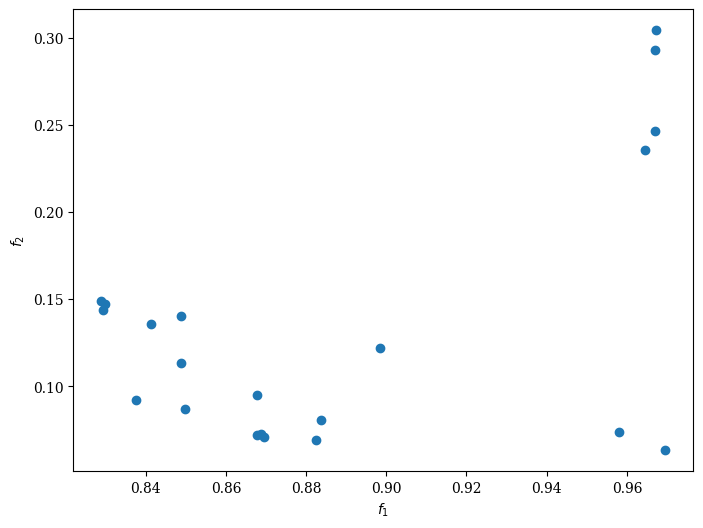

In [59]:
true_f = evaluate_zdt1(res.X)
print(true_f)
plot = Scatter().add(true_f)

plot.show()